## I. 들어가며

실험실에서 딥러닝을 의료 영상 분석에 적용할 프로젝트를 고민한 적이 있었고, 그 일환으로 폐(lung) 컴퓨터 단층촬영(CT: computed tomography) 영상에서 결절 혹은 암 따위의 오브젝트를 판별하기 위한 연구가 계획되었다. 당시 나는 **[LUNA16](https://luna16.grand-challenge.org/)** 챌린지를 중심으로 딥러닝 모델에 투입될 데이터의 전처리를 맡았는데, 이와 유사한 기존의 연구나 프로젝트들이 상당히 많았기에 진행에 큰 어려움은 없었다. 다만 그 과정들이 단순치 않아 간략히 기록으로 남긴다.

## II. 데이터 세트
LUNA16은 폐 결절과 관련된 두 가지 트랙을 챌린지 종목으로 채택하고 있다. 하나는 영상에서 결절로 의심되는 영역을 탐지하는 **Nodule detection** 이고, 다른 하나는 주어진 결절 후보들의 거짓 양성 분류율을 낮추는 **False positive reduction** 이다. LUNA16 공식 홈페이지에서 데이터 세트를 내려 받을 수 있는 링크를 제공하며, Data 섹션에 설명된 데이터 세트의 구조를 요약하면 다음과 같다.

* **subset0.zip ~ subset9.zip**: 모든 CT 영상들이 포함된 zip 파일 10개.
* **annotations.csv**: 실제 결절 위치가 저장된 csv 파일. Nodule detection 트랙에서 사용.
* **sampleSubmission.csv**: 결과 제출용 파일 양식.
* **candidates.csv**: 결절 후보(결절 또는 비결절)들의 정보가 저장된 csv 파일. 이 파일 대신 candidates_V2.csv 사용을 권고.
* **candidates_V2.csv**: 결절 후보(결절 또는 비결절)들의 정보가 저장된 csv 파일. False positive reduction 트랙에서 사용.
* **evaluation script**: 결과 검증용 스크립트.
* **lung segmentation**: 자동 알고리즘으로 계산된 폐 분할 이미지들의 디렉토리.
* **additional_annotations.csv**: 추가 결절들이 포함된 csv 파일.

우리는 CNN(convolutional neural network)을 이용해 결절의 이진 분류 성능 향상을 목표로 하였기에 두 번째 트랙과 관련된 파일인 subset\*.zip과 candidates_V2.csv를 사용하였다. 참고로 subset\*.zip은 개개의 압축 용량이 6~8GB, 압축 해제 시 12GB 이상이므로 넉넉한 시간과 여유 공간이 필요하다.

## III. 파이썬 및 라이브러리
파이썬은 다른 프로그래밍 언어보다 접근성이 좋았고 훌륭한 딥러닝 라이브러리들이 이 언어를 지원하였기에 사용하지 않을 이유가 없었다. 사용된 파이썬 버전은 3.6.5 이고 라이브러리 목록은 아래와 같다.
* **NumPy 1.16.0**: 여러 가지 계산 함수 활용
* **Pandas 0.23.4**: candidates_V2.csv 파일 처리
* **SciPy 1.2.0**: 이미지 인터폴레이션
* **SimpleITK 1.2.0**: CT 영상 파일(\*.mhd) 처리
* **Matplotlib 3.0.2**: 이미지 시각화
* **tqdm 4.29.1**: 작업 진행률 모니터링(옵션)

개발자는 리눅스 터미널이나 윈도우 명령 프롬프트에서 pip 명령어를 통해 이들을 개별적으로 설치하거나, 아니면 아나콘다를 사용할 수도 있다. 가상 환경(virtual environment)이나 미리 세팅된 도커(docker) 컨테이너도 선택지가 될 수 있으니 자세한 내용은 해당 공식 홈페이지를 참고하는 것이 좋다.

## IV. 전처리

### 1) 작업 디렉토리 구성
디렉토리 구성은 아래와 같다.
```
/notebooks
    ├ /datasets
    │    └ /luna16
    │        ├ candidates_V2.csv
    │        ├ /subset0
    │        │    ├ 1.3.6.1....1260.mhd
    │        │    ├ 1.3.6.1....1260.raw
    │        │    └ ...
    │        ├ /subset1
    │        ├ /subset2
    │        ├ ...
    │        └ /subset9
    └ /luna16
         └ preprocessing.ipynb
```
최상위 디렉토리 **/notebooks**를 기준으로 **/datasets/luna16** 디렉토리에는 CT 영상 내 결절 후보들의 정보를 담고있는 파일 candidates_V2.csv 및 실제 CT 영상 파일이 위치한 subset\* 디렉토리들이 들어있다. 이 포스트에서는 테스트 편의를 위해 subset0 ~ subset9 중 subset0만을 사용하며, 전처리 코드가 실행될 주피터 노트북 파일은 **/luna16/preprocessing.ipynb** 이다.

### 2) 결절 후보들의 정보 살펴보기
파일 candidates_V2.csv에 저장된 전체 데이터 개수 및 컬럼에 대한 설명은 공식 홈페이지에 기재되어 있다. 그러나 내가 직접 확인하는 것과는 또 다른 느낌이므로 직접 확인해 보았다.

In [1]:
%matplotlib inline

import os
from glob import glob

import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation

csv_file = '../datasets/luna16/candidates_V2.csv'
df = pd.read_csv(csv_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754975 entries, 0 to 754974
Data columns (total 5 columns):
seriesuid    754975 non-null object
coordX       754975 non-null float64
coordY       754975 non-null float64
coordZ       754975 non-null float64
class        754975 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 28.8+ MB


인덱스 0부터 754,974까지 총 754,975개의 행(결절 후보)이 있으며, 각 행은 5개 컬럼(non-null)으로 구성된 정보를 갖는다. 컬럼 coordX, coordY, 그리고 coordZ는 3차원 공간(physical space)에서 결절의 좌표를 나타내는 실수형(float64) 자료이고, seriesuid와 class는 각각 CT 영상 식별자, 클래스(결절 또는 비결절)를 의미한다. 인덱스 기준 상위 5개 행만 출력해 보겠다.

In [2]:
df.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0


컬럼 seriesuid는 각 행의 결절 후보가 소속된 \*.mhd 파일을 가리킨다. 그러나 이것만으론 각 subset 별 \*.mhd의 개수와 결절 또는 비결절의 개수가 확인되지 않는다. 코드 몇 줄 더 작성해서 실행해 보니,

In [3]:
subsets = sorted(glob('../datasets/luna16/subset*'))
mhd_files = []
for subset in subsets:
    subset_mhd_files = glob(os.path.join(subset, '*.mhd'))
    for mhd_file in subset_mhd_files:
        mhd_files.append(mhd_file)

def helper(uid):
    for mhd_file in mhd_files:
        if uid in mhd_file: return mhd_file.split('/')[-2]
        
df['dir'] = df['seriesuid'].apply(helper)
df = df.dropna()

df.sample(n=10, random_state=1)

,seriesuid,coordX,coordY,coordZ,class,dir
517454,1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348...,-59.570000,41.610000,-116.560000,0,subset4
627293,1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863...,119.370301,-2.633213,-206.089639,0,subset2
489353,1.3.6.1.4.1.14519.5.2.1.6279.6001.300271604576...,90.630000,-156.760000,-294.740000,0,subset1
141243,1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190...,-75.814176,55.680819,-177.683271,0,subset7
593558,1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369...,-22.710000,-92.710000,-68.700000,0,subset0
387517,1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203...,-52.210000,8.790000,-22.680000,0,subset2
353790,1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484...,-25.478599,-272.285994,-158.362856,0,subset8
255517,1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589...,56.770000,-197.430000,-67.200000,0,subset6
189998,1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420...,94.810000,107.810000,-148.320000,0,subset2
616267,1.3.6.1.4.1.14519.5.2.1.6279.6001.463588161905...,-58.810000,-0.190000,-91.730000,0,subset6


데이터 세트의 크기가 커서 처리에 수 초가 걸렸다. 각 결절 후보의 seriesuid를 이용해 해당 결절이 위치한 subset 이름을 새로운 컬럼 dir에 추가한 후, 모집단에서 10개의 샘플을 랜덤 샘플링 해보았다(랜덤시드 1). 모든 행에 대한 세부 정보를 살펴보면 다음과 같다.

In [4]:
print('1. DataFrameInfo')
print(' - tot seriesuid:', len(df['seriesuid'].value_counts()))
print(' - tot subsets:', len(df['dir'].value_counts()))
cls0, cls1 = df['class'].value_counts()
print(' - tot rows(nodule:non-nodule):', len(df), '(%d:%d)' % (cls1, cls0))

print('\n2. SubsetInfo [subset: rows(nodule:non-nodule)]')
for subset in subsets:
    subset_name = subset.split('/')[-1]
    subset_df = df[df['dir'] == subset_name]
    rows = len(subset_df)
    cls0, cls1 = subset_df['class'].value_counts()
    print(' - ' + subset_name + ':', rows, '(%d:%d)' % (cls1, cls0))

1. DataFrameInfo
 - tot seriesuid: 888
 - tot subsets: 10
 - tot rows(nodule:non-nodule): 754975 (1557:753418)

2. SubsetInfo [subset: rows(nodule:non-nodule)]
 - subset0: 79135 (138:78997)
 - subset1: 71012 (170:70842)
 - subset2: 74458 (181:74277)
 - subset3: 75950 (158:75792)
 - subset4: 76583 (170:76413)
 - subset5: 75691 (127:75564)
 - subset6: 76671 (154:76517)
 - subset7: 75063 (120:74943)
 - subset8: 74488 (195:74293)
 - subset9: 75924 (144:75780)


총 888개의 seriesuid(\*.mhd files)가 존재, 클래스는 0(비결절)과 1(결절)로 분류되고 개수는 각각 753,418개, 1,557개이다. 결절 비결절 데이터 개수 비율이 대략 1:483으로 굉장히 언밸런스하고 이러한 양상이 모든 subset에서 나타난다. 딥러닝에서 학습데이터 불균형은 매우 흔하지만 수 백 배수 이상 차이가 난다면 모델의 일반화 성능 향상을 기대하기 어렵다. 이러한 상황에선 어느 한 쪽의 데이터를 다른 쪽의 데이터 개수에 맞추는 업샘플링(upsampling) 또는 다운샘플링(downsampling)을 고려할 수 있다. 연구가 진행될 당시, 우리는 결절 1,557개를 비결절 개수와 비슷해지도록 데이터 증강(data augmentation) 작업을 추가하기로 하였고, 나는 그 코드를 1차 전처리 작업이 완료된 후에 작성했었다. 추후 이 내용을 포스팅할 예정이다.

### 3) CT 영상 살펴보기
돌이켜 보면 전처리 작업 초기에 나는 CT 영상이 단순히 이미지들의 묶음으로 구성 되었을 것이다 생각하고 굉장히 자만했었는데 의외로 복잡한 개념을 포함하고 있어 당황했던 기억이 난다. 특히 **Voxel space**와 **Physical space**의 상호변환과 **Slicing thickness**에 대한 개념 자체가 없었기에 꽤나 삽질했다. 내려받은 CT 영상이 \*.dcm 이 아닌  \*.mhd 파일 확장자(Insight Meta-Image)였다는 것도 한 몫 했다. 나는 이것들의 관계나 차이를 아직 명확히 알지 못하기 때문에 세부 내용은 다시 업데이트 할 것이다. 지난 기억을 정리하는 지금 시점에선 정말 어려울 것 하나 없는 과정인데 왜 그렇게 애먹었는지 모르겠다.

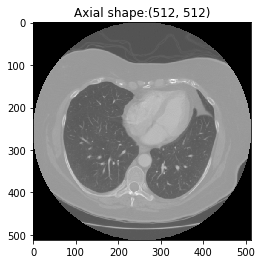

In [5]:
index = 42 # in subset0
img = sitk.ReadImage(mhd_files[index])
imgarr = sitk.GetArrayFromImage(img)

img_axial = imgarr[len(imgarr)//2] # imgarr[len(...)//2, :, :]과 동일
plt.title("Axial shape:" + str(np.shape(img_axial)))
plt.imshow(img_axial, cmap='gray')

라인 1과 2에서 \*.mhd 파일 888개 중 43번째 파일(subset0 하위에 존재)의 raw 데이터를 변수 img에 저장하였고, 라인 3에서 이를 리스트(배열)로 다시 변환(from physical space to voxel space)하여 변수 imgarr에 저장하고 있다. 여기서 입력된 의료 영상은 2차원 단층 영상의 시리즈(series) 데이터이므로 imgarr은 3차원 리스트가 된다. 따라서 2차원 횡단면(axial plane) 영상을 얻기 위해 라인 5에서 3차원 리스트 슬라이싱을 사용하였고, 그 영상을 변수 img_axial에 저장하였다. 라인 6~7은 이를 출력하는 코드다. 출력 이미지만 보면 라인 3에서 이미 양자화(quantization)가 진행되었으므로 이 상태 그대로 직렬화(serialization)하면 될 것 같지만 그건 큰 오산이다. 다음 코드를 보자.

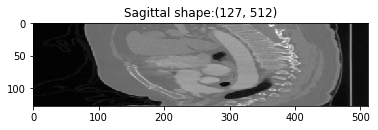

In [6]:
img_sagittal = imgarr[:, :, len(imgarr[0][0])//2]
plt.title("Sagittal shape:" + str(np.shape(img_sagittal)))
plt.imshow(img_sagittal, cmap='gray')

위 출력은 동일한 imgarr에서 시상면(sagittal plane)을 슬라이싱하여 출력한 결과이다. 횡단면 이미지와 달리, 흉부 길이가 비정상적으로 짧으며 그레이 레벨(gray level) 범위 또한 달라 보인다. 이는 관상면(coronal plane) 이미지 또한 마찬가지다.

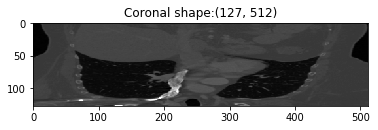

In [7]:
img_coronal = imgarr[:, len(imgarr[0])//2, :]
plt.title("Coronal shape:" + str(np.shape(img_coronal)))
plt.imshow(img_coronal, cmap='gray')

왜 이런 결과가 나타날까? 바로 **Slicing thickness** 때문이다. 이 개념은 식빵을 칼로 자르는 것에 비유하여 쉽게 설명할 수 있다. 잘려진 빵의 단면을 앞서 보았던 횡단면 영상이라고 가정해보자. 이 영상들이 자연스럽게 연속적으로 보이도록 만드려면 빵을 아주 얇게 썰어야 할 것이다. 그러나 현실적으로 두께 조절에 어려운 부분이 있는데 [국제방사선방호위원회 간행물](http://www.icrp.org/docs/P087_Korean_CT.pdf)에 따르면 CT 촬영 시 슬라이스 두께에 따라 환자가 받는 방사선 피폭 정도가 달라진다고 하니, 이유야 어찌됐건 우리는 슬라이싱 두께를 고려하여 인터폴레이션(interpolation)을 수행해야 하겠다.

그러나 새로운 복병이 기다리고 있었으니, 바로 candidates_V2.csv에 저장된 결절 후보의 좌표다. imgarr이 재배열된다면 각 요소의 위치도 완전히 달라지므로 동일한 변환 로직을 좌표에도 적용해 주어야 할텐데 어떻게 할까? 게다가 데이터프레임에 저장된 coordX, coordY, 그리고 coordZ 값은 Physical space의 좌표(실수형)다. 내가 여기서 가장 많은 시간을 소모했다.

### 4) 리샘플 및 노멀라이즈
이제 Slicing thickness를 고려한 리샘플 및 노멀라이즈 방법에 대하여 기술한다. 적용 대상은 imgarr과 결절 후보 좌표값들이다. 아래 코드는 리샘플 및 노멀라이즈 함수를 구현한 것으로, 리샘플 구현부는 **[Kaggle](https://www.kaggle.com/)**에서 활동하는 **[Guido Zuidhof](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial)**의 문서를 참고하여 작성하였음을 밝힌다(세부 내용이 궁금하면 링크를 참조할 것). 

In [8]:
def _real_resize_factor(shape, spacing, adj_spacing=None):
    if adj_spacing is None:
        adj_spacing = list(np.ones_like(shape))
    new_shape = np.round(shape * (spacing / adj_spacing))
    real_resize_factor = new_shape / shape
    return real_resize_factor

def resample(imgarr, spacing):
    real_resize_factor = _real_resize_factor(imgarr.shape, spacing)
    spacing = spacing / real_resize_factor
    imgarr = interpolation.zoom(imgarr, real_resize_factor, mode='nearest')
    return imgarr, spacing

def normalize(imgarr, norm_min, norm_max):
    imgarr = np.where(imgarr < norm_min, norm_min, imgarr)
    imgarr = np.where(imgarr > norm_max, norm_max, imgarr)
    imgarr = (imgarr + abs(norm_min)) / (abs(norm_min) + abs(norm_max))
    return imgarr

함수 \_real_resize_factor()는  축(z, y, x)별 리사이징 계수를 반환하고, 함수 resample()은 이를 이용하여 재계산된(변환된) imgarr 과 spacing 정보를 반환한다. 함수 normalize()는 imgarr 의 픽셀값을 미리 지정된 상하한에 따라 조절하는데, 하운스필드 유닛(HU: Hounsfield Unit) 스케일에 맞게 처리하여야 한다. 리샘플 및 노멀라이즈를 imgarr에 적용하는 코드는 아래와 같다.

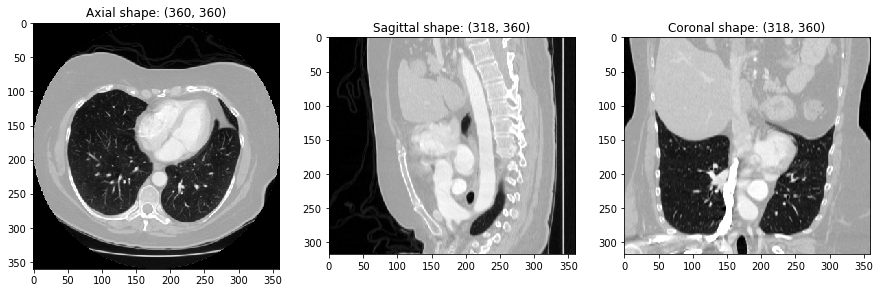

In [9]:
origin = np.array(img.GetOrigin())[::-1]
spacing = np.array(img.GetSpacing())[::-1]

imgarr, spacing = resample(imgarr, spacing)
imgarr = normalize(imgarr, -1000, 400)

img_titles = ['Axial', 'Sagittal', 'Coronal']
img_planes = [
    imgarr[len(imgarr)//2],
    imgarr[:, :, len(imgarr[0][0])//2],
    imgarr[:, len(imgarr[0])//2, :]
]

fig, axes = plt.subplots(1, 3, figsize=(15, 10))
for i in range(len(img_titles)):
    axes[i].set_title(img_titles[i] + ' shape: ' + str(img_planes[i].shape))
    axes[i].imshow(img_planes[i], cmap='gray')
plt.show()

라인 1과 2는 \*.mhd 파일에 저장된 origin 및 spacing 정보(slicing thickness 등 축 별 간격 정보)를 가져오는 것이고, 그 다음 라인부터는 이에 따라 리샘플 및 노멀라이즈 적용 후 이미지를 출력하는 과정이다. 앞선 출력들보다 훨씬 자연스러움을 알 수 있다. 다음은 같은 방법으로 좌표 정보를 수정하는 코드이다.

In [10]:
df = df[df['seriesuid']==mhd_files[index].split('/')[-1][:-4]]
df = df[df['class']==1]
df = df.drop(labels=['seriesuid', 'dir'], axis=1)
df['file'] = mhd_files[index]
df['vcoordX'], df['vcoordY'], df['vcoordZ'] = [np.nan] * 3

df.head()

,coordX,coordY,coordZ,class,file,vcoordX,vcoordY,vcoordZ
688857,56.049356,67.071147,-65.025644,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,NaN,NaN,NaN
689225,51.946869,74.053131,-70.250000,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,NaN,NaN,NaN
689295,51.243744,62.803131,-70.250000,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,NaN,NaN,NaN
689320,56.165619,68.428131,-57.750000,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,NaN,NaN,NaN
689415,61.087494,71.943756,-67.750000,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,NaN,NaN,NaN


데이터 규모가 크므로 특정 mhd 파일의 결절(class=1) 행을 제외한 모든 행은 제거한 후, 파일 경로 및 voxel space 좌표가 저장될 새로운 컬럼들을 추가하고 불필요한 컬럼은 삭제하였다. 이 mhd 파일에는 실제 결절이 5개(우연히 df.head()의 출력 개수와 맞아 떨어졌다) 존재함을 확인할 수 있다. 다음은 origin과 리샘플 함수로 얻어진 새로운 spacing을 활용하여 복셀 좌표를 계산하는 코드이다.

In [11]:
for i, row in df.iterrows():
    center = np.array([row['coordZ'], row['coordY'], row['coordX']])
    vcenter = np.rint((center - origin) / spacing)
    df.at[i, 'vcoordZ'] = vcenter[0]
    df.at[i, 'vcoordY'] = vcenter[1]
    df.at[i, 'vcoordX'] = vcenter[2]

df = df.drop(labels=['coordX', 'coordY', 'coordZ'], axis=1)
df.head()

,class,file,vcoordX,vcoordY,vcoordZ
688857,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,240.0,230.0,271.0
689225,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,236.0,237.0,265.0
689295,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,235.0,226.0,265.0
689320,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,240.0,231.0,278.0
689415,1,../datasets/luna16/subset0/1.3.6.1.4.1.14519.5...,245.0,235.0,268.0


깔끔, 그 자체.

### 5) 결절 영역 추출하기
드디어 1차 전처리의 막바지에 이르렀다. 리샘플된 imgarr 및 voxel coordinates를 이용하여 실제 결절 영역을 크롭할 것이다. 다음을 보자.

In [12]:
def extract(imgarr, pos, size, margin):
    shape = imgarr.shape
    half_size = np.rint(size / 2)
    vmin = (pos - half_size) - margin
    vmin = [np.max([0, int(i)]) for i in vmin]
    vmax = vmin + size + (margin * 2)
    vmax = [np.min([ax, int(i)]) for ax, i in zip(shape, vmax)]
    return imgarr[vmin[0]:vmax[0], vmin[1]:vmax[1], vmin[2]:vmax[2]]

def wrap(cand_arr, size):
    shape = cand_arr.shape
    wrapped = np.ones(size) * np.min(cand_arr)
    vmin = np.rint((size - shape) / 2)
    vmin = np.array([int(i) for i in vmin])
    vmax = vmin + shape
    wrapped[vmin[0]:vmax[0], vmin[1]:vmax[1], vmin[2]:vmax[2]] = cand_arr
    return wrapped

함수 extract()는 pos(position, 결절 위치를 의미)를 중심으로 size와 margin에 따라 결절 영역(이하 큐브)을 크롭하며, 함수 wrap()은 큐브의 일부가 imgarr 공간을 벗어나는 경우(결절 좌표와 imgarr 외곽 사이의 거리가 결절 반경보다 짧을 때) 큐브 크기가 달라지기 때문에 이를 일정하게 맞추기 위해 사용된다. 함수 내용은 어려울 것이 없으니 설명하지 않는다.

In [13]:
size, margin = np.array([56, 56, 56]), 0

cubes = []
for i, row in df.iterrows():
    vcenter = np.array([row['vcoordZ'], row['vcoordY'], row['vcoordX']])
    cand_arr = extract(imgarr, vcenter, size, margin)
    cand_arr = wrap(cand_arr, size)
    cubes.append(cand_arr)
    
for i, cube in enumerate(cubes):
    print('cube-%d:' % i, cube.shape)

cube-0: (56, 56, 56)
cube-1: (56, 56, 56)
cube-2: (56, 56, 56)
cube-3: (56, 56, 56)
cube-4: (56, 56, 56)


라인 1은 크롭될 큐브의 사이즈를 세 축 모두 56으로 지정하였고, 마진은 주지 않았다. 라인 10~11은 (리샘플 및 노멀라이즈 단계에서 보았던) 크롭된 큐브 5개에 대한 형상 정보를 출력한다. 크롭이 완료되었으니 이제 결절들의 면상을 한번 관찰해본다.

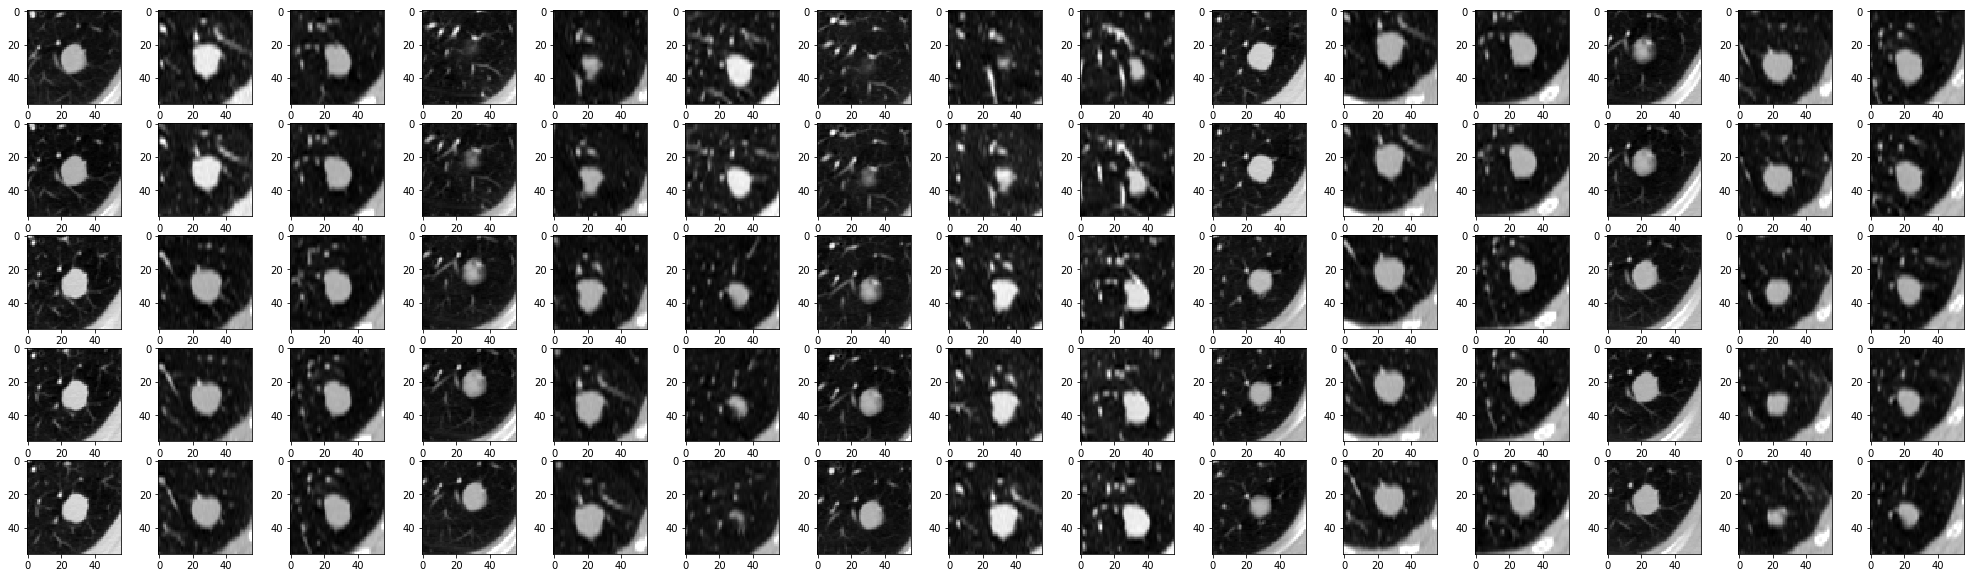

In [14]:
plane = ['ax', 'sg', 'cn'] # axial, sagittal, coronal
phase = [0.45, 0.475, 0.5, 0.525, 0.55]

fig, axes = plt.subplots(len(phase), len(plane)*5, figsize=(35,10))
for i in range(len(phase)):
    for j in range(len(plane)*5):
        idx = j // 3
        if j % 3 == 0:   # axial plane
            img = cubes[idx][int(len(cubes[idx])*phase[i]),:,:]
        elif j % 3 == 1: # sagittal plane
            img = cubes[idx][:,:,int(len(cubes[idx][0][0])*phase[i])]
        else:            # coronal plane
            img = cubes[idx][:,int(len(cubes[idx][0])*phase[i]),:]
        axes[i][j].imshow(img, cmap='gray')
plt.show()

5개 큐브에 대하여 axial, sagittal, 그리고 coronal 단면을 각 축의 중심 위치를 기준으로 다섯 단계를 설정하여 출력한 것이다. 축제목을 정하기 귀찮아 단면만 출력되도록 코딩하였지만 직감적으로 연속된 단면이 축에 따라 나열된 것임을 알 수 있다. 앞서 기재한 모든 코드를 subset0 뿐만 아니라 다른 subset에도 적용되도록 작성하면 1차 전처리를 손쉽게 수행할 수 있다.

## V. 마무리
이 포스트에서는 폐 CT 영상 데이터 세트 및 분석, 전처리에 대한 대략적인 내용을 다루어 보았다. 보편적으로 의료 영상 처리에는 세그먼테이션을 통해 어떤 영역, 예를 들어 분석을 원하는 장기 따위를 표지하는 작업이 선행되는데, 그런 작업이 인간에 의한 특징 추출 작업(handcrafted feature extraction)이라면 딥러닝은 이 작업을 스스로 하기에 우리는 단순히 결절 영역만 크롭하여 데이터 증강 후 모델에 투입시켰었다. 개인적으로 더 고급스러운 전처리가 적용되었더라면 결과는 어떻게 바뀌었을까 궁금하기도 하다. 지금껏 다룬 모든 코드 조각들을 종합한 최종본을 끝으로 포스팅을 마무리한다. 다음 포스트는 2차 전처리에 대하여 다룰 예정이다.

In [15]:
# Author: Seunghyun Kim
# Date: 18 Feb 2019
# Last updated: 21 Feb 2019

import os
from collections import namedtuple
from glob import glob
import warnings

import numpy as np
import pandas as pd
import SimpleITK as sitk
from scipy.ndimage import interpolation
from tqdm import tqdm


def _real_resize_factor(shape, spacing, adj_spacing=None):
    if adj_spacing is None:
        adj_spacing = list(np.ones_like(shape))
    new_shape = np.round(shape * (spacing / adj_spacing))
    real_resize_factor = new_shape / shape
    return real_resize_factor


def _resample(imgarr, spacing, only_csv):
    real_resize_factor = _real_resize_factor(imgarr.shape, spacing)
    spacing = spacing / real_resize_factor
    if only_csv:
        imgarr = None
    else:
        imgarr = interpolation.zoom(imgarr, real_resize_factor, mode='nearest')
    return imgarr, spacing


def _normalize(imgarr, norm_min, norm_max):
    imgarr = np.where(imgarr < norm_min, norm_min, imgarr)
    imgarr = np.where(imgarr > norm_max, norm_max, imgarr)
    imgarr = (imgarr + abs(norm_min)) / (abs(norm_min) + abs(norm_max))
    return imgarr


def _extract(imgarr, pos, size, margin):
    shape = imgarr.shape
    half_size = np.rint(size / 2)
    vmin = (pos - half_size) - margin
    vmin = [np.max([0, int(i)]) for i in vmin]
    vmax = vmin + size + (margin * 2)
    vmax = [np.min([ax, int(i)]) for ax, i in zip(shape, vmax)]
    return imgarr[vmin[0]:vmax[0], vmin[1]:vmax[1], vmin[2]:vmax[2]]


def _wrap(cand_arr, size):
    shape = cand_arr.shape
    wrapped = np.ones(size) * np.min(cand_arr)
    vmin = np.rint((size - shape) / 2)
    vmin = np.array([int(i) for i in vmin])
    vmax = vmin + shape
    wrapped[vmin[0]:vmax[0], vmin[1]:vmax[1], vmin[2]:vmax[2]] = cand_arr
    return wrapped


def unzip_data(input_dir, output_dir):
    """
    Unzip all data.

    We assume that you have downloaded all the necessary data from
    the [LUNA16](https://luna16.grand-challenge.org) website. This
    task requires at least 120 Gb of free space and 7-zip package.
    If you see that the command is not found when you run the task,
    see the following URL: https://www.7-zip.org/
    """
    
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
        
    zip_files = glob(os.path.join(input_dir, '*.zip'))
    zip_files.sort()
    for zip_file in tqdm(zip_files):
        os.system('7z x ' + zip_file + ' -o' + output_dir + ' -aos')


def resample_mhd_to_npy(input_dir, output_dir, csv_file, norm_min, norm_max,
                        only_csv=False):
    """
    Resample all mhd to npy.

    For preprocessing the data, resamples the coordinate system of
    raw files into a voxel-based coordinate system. This task takes
    a lot of time, so it is a good idea to save the results. But it
    requires at least 290 Gb of free space.
    
    Sometimes you only need a voxel CSV file. If you set the variable
    only_csv to True, resample_mhd_to_npy() save only the voxel CSV
    file. This takes a short time to calculate.
    """
    
    if not only_csv and os.path.isdir(output_dir):
        msg = 'The output directory already exists. ' + \
              'If you want to resample again, delete ' + \
              'the output directory and try again.'
        assert False, msg
        
    Subset = namedtuple('Subset', ['path', 'mhd_files'])
    
    subset_dirs = glob(os.path.join(input_dir, 'subset*'))
    subset_dirs.sort()
    
    subsets = []
    for subset_dir in subset_dirs:
        mhd_files = glob(os.path.join(subset_dir, '*.mhd'))
        subset = Subset(subset_dir, mhd_files)
        subsets.append(subset)
        
    def get_file_name(seriesuid):
        for subset in subsets:
            for mhd_file in subset.mhd_files:
                if seriesuid in mhd_file:
                    return mhd_file
    
    df = pd.read_csv(csv_file)
    df['file'] = df['seriesuid'].apply(get_file_name)
    df = df.dropna()
    df['vcoordX'], df['vcoordY'], df['vcoordZ'] = np.nan, np.nan, np.nan
    df['npy_file'] = None

    for subset in subsets:
        subset_name = os.path.basename(subset.path)
        new_subset_path = os.path.join(output_dir, subset_name)
        if not only_csv:
            os.makedirs(new_subset_path)
        
        for mhd_file in tqdm(subset.mhd_files):
            df_mhd = df[df['file'] == mhd_file]
            
            if df_mhd.shape[0] > 0:
                mhd_uid = str(os.path.basename(mhd_file)[:-4].split('.')[-1])
                npy_name = subset_name + '_' + mhd_uid + '.npy'
                npy_path = os.path.join(new_subset_path, npy_name)
                
                img = sitk.ReadImage(mhd_file)
                imgarr = sitk.GetArrayFromImage(img)
                origin = np.array(img.GetOrigin())[::-1]
                spacing = np.array(img.GetSpacing())[::-1]
                
                imgarr, spacing = _resample(imgarr, spacing, only_csv)
                if not only_csv:
                    imgarr = _normalize(imgarr, norm_min, norm_max)
                    np.save(npy_path, imgarr)
                
                for i, row in df_mhd.iterrows():
                    center = np.array([row['coordZ'], row['coordY'], row['coordX']])
                    vcenter = np.rint((center - origin) / spacing)
                    df.at[i, 'vcoordZ'] = vcenter[0]
                    df.at[i, 'vcoordY'] = vcenter[1]
                    df.at[i, 'vcoordX'] = vcenter[2]
                    df.at[i, 'npy_file'] = npy_name

    df = df.drop(['seriesuid', 'coordX', 'coordY', 'coordZ', 'file'], axis=1)
    new_csv_file = os.path.join(output_dir, 'voxel_' + os.path.basename(csv_file))
    df.to_csv(new_csv_file)


def extract_candidate(input_dir, output_dir, csv_file, size, margin=0, get_2d=True):
    """
    Extract all candidates from npy files.

    This task takes a lot of time, so it is a good idea to save
    the results. The required free space depends on the variables
    extract_size, margin, and get_2d.
    """
    
    if os.path.isdir(output_dir):
        msg = 'The output directory already exists. ' + \
              'If you want to resample again, delete ' + \
              'the output directory and try again.'
        assert False, msg
    
    if type(size) == type([]):
        size = np.array(size)

    Subset = namedtuple('Subset', ['path', 'npy_files'])
    
    subset_dirs = glob(os.path.join(input_dir, 'subset*'))
    subset_dirs.sort()
    
    subsets = []
    for subset_dir in subset_dirs:
        npy_files = glob(os.path.join(subset_dir, '*.npy'))
        subset = Subset(subset_dir, npy_files)
        subsets.append(subset)
        
    df = pd.read_csv(csv_file)
    fill = len(str(len(df)))
    
    for subset in subsets:
        subset_name = os.path.basename(subset.path)
        new_subset_path = os.path.join(output_dir, subset_name)
        os.makedirs(new_subset_path)
        
        for npy_file in tqdm(subset.npy_files):
            npy_name = os.path.basename(npy_file)
            df_npy = df[df['npy_file'] == npy_name]
            imgarr = np.load(npy_file)
            
            for i, row in df_npy.iterrows():
                vcenter = np.array([row['vcoordZ'], row['vcoordY'], row['vcoordX']])
                cand_arr = _extract(imgarr, vcenter, size, margin)
                cand_arr = _wrap(cand_arr, size)
                if get_2d:
                    cand_arr = cand_arr[int(cand_arr.shape[0]/2)]
                tag_r = 'row' + str(i).zfill(fill)
                tag_c = '_cls' + str(row['class'])
                cand_name = tag_r + tag_c + '.npy'
                cand_path = os.path.join(new_subset_path, cand_name)
                np.save(cand_path, cand_arr)


def main():
    warnings.filterwarnings('ignore', '.*output shape of zoom.*')

    # origin_dir:
    #   The directory path containing the compressed files downloaded from the website.
    #   The compression files we used are listed below:
    #   subset0.zip, ..., subset9.zip, candidates_V2.zip (total 11)
    #
    # unzip_dir:
    #   The directory path where the extracted files will be stored.
    #
    # resample_dir:
    #   The directory path where resampled data will be stored.
    #
    # extract_dir:
    #   The directory path where extracted candidates will be stored.
    origin_dir = '/data/datasets/luna16-origin'
    unzip_dir = '/data/datasets/luna16-unzip'
    resample_dir = '/data/datasets/luna16-resample'
    extract_dir = '/data/datasets/luna16-extracted'

    # Step 1. Unzip all data.
    #   We assume that you have downloaded all the necessary data from
    #   the [LUNA16](https://luna16.grand-challenge.org) website. This
    #   task requires at least 120 Gb of free space and 7-zip package.
    #   If you see that the command is not found when you run the task,
    #   see the following URL: https://www.7-zip.org/
    unzip_data(origin_dir, unzip_dir)

    # Step 2. Resample all mhd to npy.
    #   For preprocessing the data, resamples the coordinate system of
    #   raw files into a voxel-based coordinate system. This task takes
    #   a lot of time, so it is a good idea to save the results. But it
    #   requires at least 290 Gb of free space.
    #
    #   Sometimes you only need a voxel CSV file. If you set the variable
    #   only_csv to True, resample_mhd_to_npy() save only the voxel CSV
    #   file. This takes a short time to calculate.
    csv_file = os.path.join(unzip_dir, 'candidates_V2.csv')
    norm_min, norm_max = -1000, 400
    only_csv = False

    resample_mhd_to_npy(unzip_dir, resample_dir, csv_file, norm_min, norm_max, only_csv)

    # Step 3. Extract all candidates from npy files.
    #   This task takes a lot of time, so it is a good idea to save the
    #   results. The required free space depends on the variables
    #   extract_size, margin, and get_2d.
    voxel_csv_file = os.path.join(resample_dir, 'voxel_candidates_V2.csv')
    extract_size = [56, 56, 56]

    extract_candidate(resample_dir, extract_dir, voxel_csv_file, extract_size)


if __name__ == '__main__':
    pass
    #main()